In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import requests
import urllib
import os
from PIL import Image
from skimage.filters import threshold_otsu
%matplotlib inline

In [2]:
def resize_padded(img, new_shape, fill_cval=None, order=1):
    import numpy as np
    from skimage.transform import resize
    if fill_cval is None:
        fill_cval = np.max(img)
    ratio = np.min([n / i for n, i in zip(new_shape, img.shape)])
    interm_shape = np.rint([s * ratio for s in img.shape]).astype(np.int)
    interm_img = resize(img, interm_shape, order=order, cval=fill_cval)

    new_img = np.empty(new_shape, dtype=interm_img.dtype)
    new_img.fill(fill_cval)

    pads = [((n-s-1)//2, (n-s+1)//2) for n, s in zip(new_shape, interm_shape)]
    new_img[[slice(p1, -p2, None) if 0 != p2 else slice(None, None, None) 
             for p1, p2 in pads]] = interm_img

    return new_img

def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

In [3]:
DISPLAY_WIDTH = 96
DISPLAY_HEIGHT = 27

In [4]:
FN = 'http://www.freeiconspng.com/uploads/blue-snow-icon-8.png'
#FN = 'http://www.freeiconspng.com/uploads/black-autumn-leaf-icon-7.jpeg'
urllib.request.urlretrieve(FN, 'image')
im = Image.open('image')

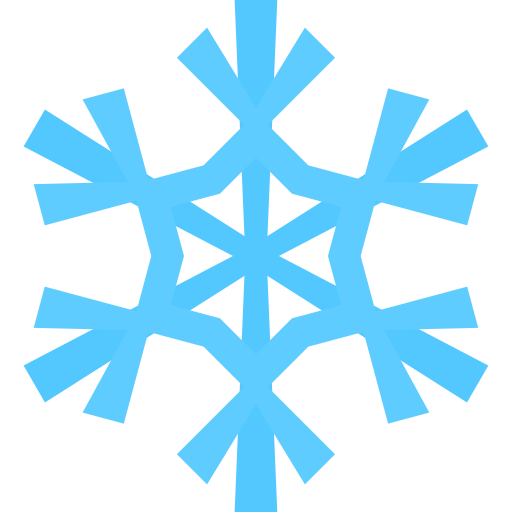

In [5]:
im

In [6]:
im = np.array(remove_transparency(im).convert('L')) # make grayscale array

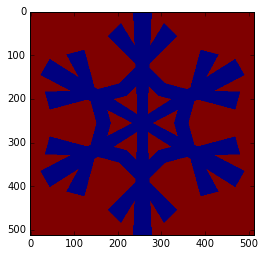

In [7]:
im = im > threshold_otsu(im) # threshold to BW
plt.imshow(im)

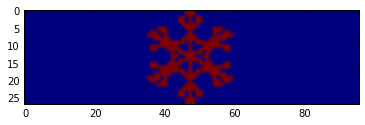

In [8]:
# resize and threshold again
im = resize_padded(im, (DISPLAY_HEIGHT, DISPLAY_WIDTH))
im = im > threshold_otsu(im)

# make background dark
if im.mean() > 0.5:
    im = (im == 0)

plt.imshow(im)

In [26]:
# put image data into C code string

s = 'static const unsigned char buf[] = {'
for y in range(DISPLAY_HEIGHT):
    for x in range(DISPLAY_WIDTH):
        s += '%d,' % im[DISPLAY_HEIGHT - 1 - y, x]
s = s[:-1]
s += '};'

In [27]:
with open('buf.h', 'w') as of:
    of.write(s)

In [28]:
# upload source to particle.io cloud firmware update

#files = {'base.cpp': open('base.ino','rb'), 'buf.h': open('buf.h', 'rb')}
files = {'base.cpp': open('scroll.ino','rb'), 'buf.h': open('buf.h', 'rb')}
url = 'https://api.particle.io/v1/devices/{}?access_token={}'.format(
    os.environ['PARTICLE_ID'],
    os.environ['TOKEN'])

r = requests.put(url,files=files)

print(r, r.text)

<Response [200]> {"ok":true,"message":"Update started"}
